In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


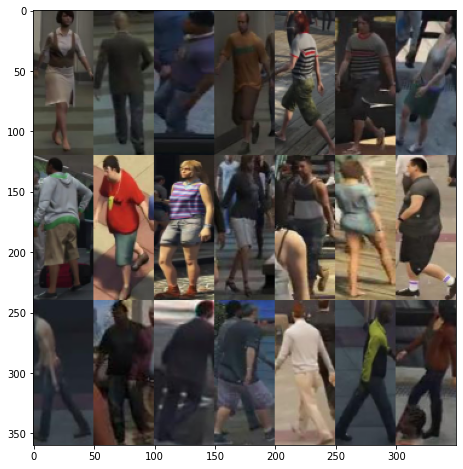

In [170]:
import matplotlib.pyplot as plt
im = plt.imread("./checkpoints/no_wgan_loss_v12/sample/000000.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

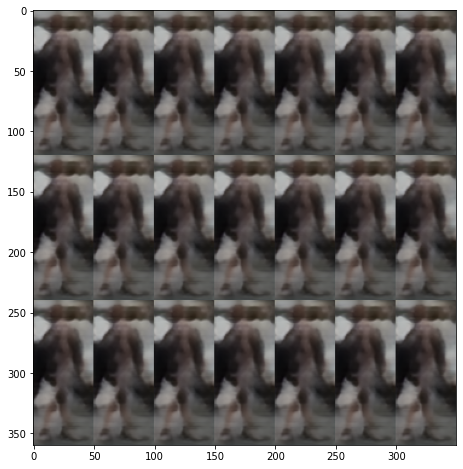

In [173]:
im_num = 160000
import matplotlib.pyplot as plt
im = plt.imread(f"./checkpoints/no_wgan_loss_v12/sample/{str(im_num).zfill(6)}.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

In [1]:
from model import StyledGenerator
from dataset import AlignedDatasetLoader
from torchvision import transforms
import torch
from torch import nn
import matplotlib.pyplot as plt
import random
from time import time
import numpy as np
from skimage import transform as sk_transform

In [35]:

transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )

dataset = AlignedDatasetLoader('../../datasets/JTA_parsed', '../../datasets/DukeMTMC', transform, resolution = 128)

def get_generator(load_name, code_size, n_mlp, use_cls, static_noise, active_style_layers, decoder):
    generator = StyledGenerator(code_size, n_mlp = n_mlp, classes = dataset.total_ids, use_cls = use_cls, static_noise = static_noise, active_style_layers = active_style_layers, decoder = decoder)

    device = torch.device('cuda')

    ckpt = torch.load(load_name, map_location=device)

    generator.load_state_dict(ckpt['g_running'])
    
    generator.train(False)
    return generator

In [31]:
def show_resized_images(images):
    num_cols = 10
    num_rows = 1
    target_shape = (120, 50)
    result_image = np.zeros((num_rows * target_shape[0], num_cols * target_shape[1], 3), dtype = np.float32)
    for nr in range(num_rows):
        for nc in range(num_cols):
            im = images[nr * num_cols + nc]
            if len(im.size()) == 4:
                im = im[0]
            im = torch.clamp(im, -1, 1).detach().cpu().numpy()
            im = (np.transpose(im, (1, 2, 0)) + 1) / 2.0 * 255.0
            im = sk_transform.resize(im, target_shape)
            result_image[target_shape[0] * nr:target_shape[0] * (nr + 1), target_shape[1] * nc:target_shape[1] * (nc + 1), :] = im[:, :, :]
    plt.figure(figsize=(16, 10))
    plt.imshow(result_image.astype(np.uint8))
    plt.show()

In [4]:
random.seed(0)
fixed_idxs = [random.randint(0, len(dataset)) for i in range(10)]
random.seed(time())
image_batch = torch.cat([dataset[i]['img_from'].unsqueeze(0) for i in fixed_idxs], 0)

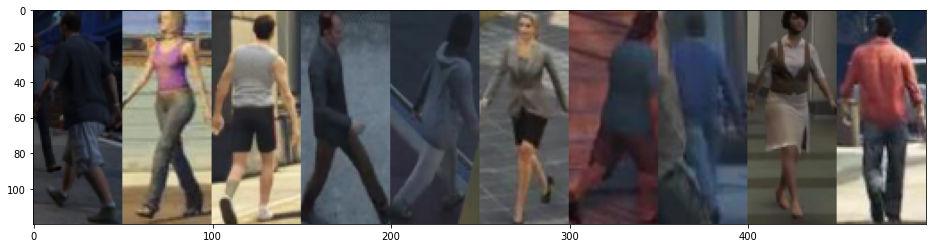

In [32]:
show_resized_images(image_batch)

In [33]:
exp_name = ['no_wgan_loss_v3', 'no_wgan_loss_v4', 'no_wgan_loss_v6', 'no_wgan_loss_v7', 'no_wgan_loss_v8', 'no_wgan_loss_v12']
mlps = [8, 8, 4, 4, 4, 4]
code_sizes = [512, 512, 512, 512, 2048, 512]
use_cls = [True, True, True, True, False, True]
static_noises = [False, False, True, True, True, True]
active_style_layers = [14, 14, 14, 10, 14, 14]
decoders = ['base', 'base', 'base', 'base', 'resnet50', 'resnet50']

Experiment name: no_wgan_loss_v3, Code size: 512, n_mlp: 8, use_cls: True, static_noise: False, active_style_layers: 14, decoder: base


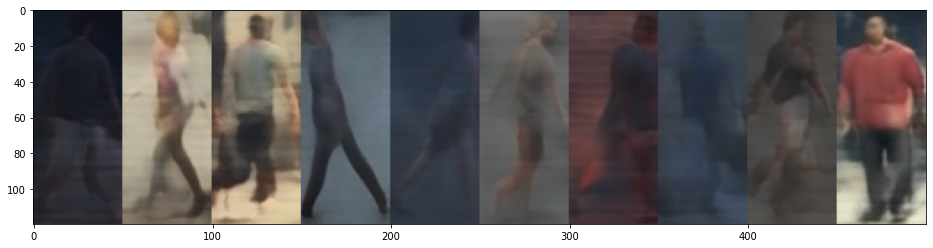

Experiment name: no_wgan_loss_v4, Code size: 512, n_mlp: 8, use_cls: True, static_noise: False, active_style_layers: 14, decoder: base


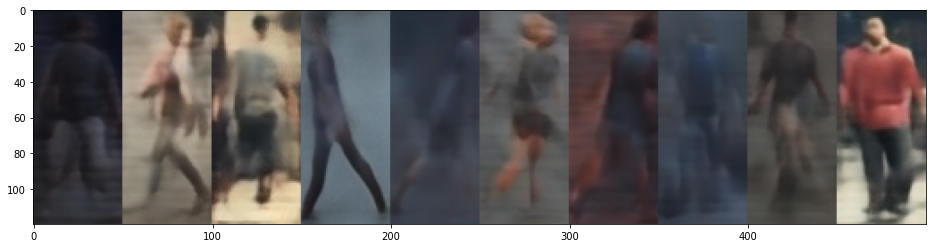

Experiment name: no_wgan_loss_v6, Code size: 512, n_mlp: 4, use_cls: True, static_noise: True, active_style_layers: 14, decoder: base


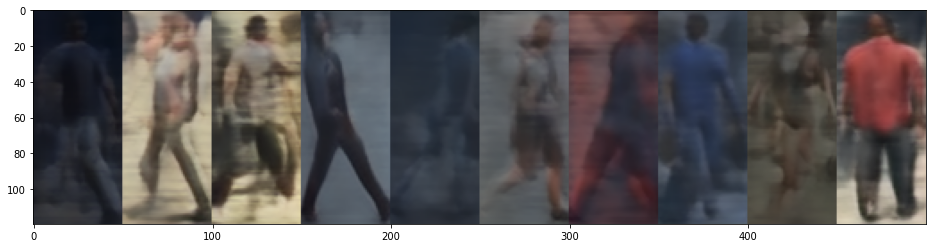

Experiment name: no_wgan_loss_v7, Code size: 512, n_mlp: 4, use_cls: True, static_noise: True, active_style_layers: 10, decoder: base


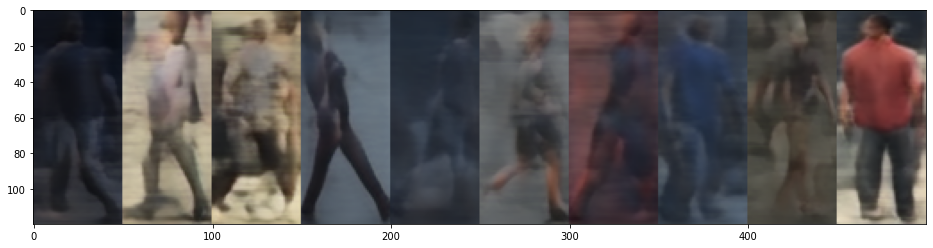

Experiment name: no_wgan_loss_v12, Code size: 512, n_mlp: 4, use_cls: True, static_noise: True, active_style_layers: 14, decoder: resnet50


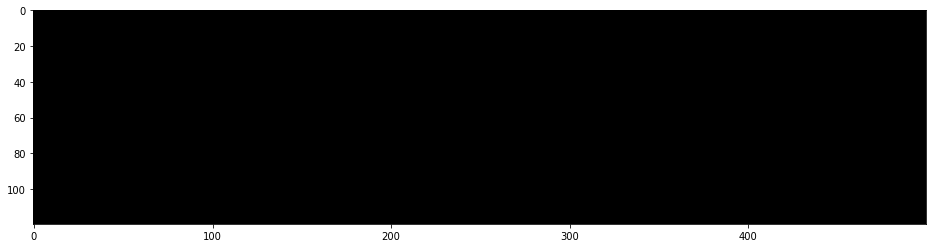

In [39]:
for e, m, c, us, st, ac, dec in zip(exp_name, mlps, code_sizes, use_cls, static_noises, active_style_layers, decoders):
    if e == 'no_wgan_loss_v8':
        continue
    print(f'Experiment name: {e}, Code size: {c}, n_mlp: {m}, use_cls: {us}, static_noise: {st}, active_style_layers: {ac}, decoder: {dec}')
    generator = get_generator("./checkpoints/" + e + "/160000_128.model", c, m, us, st, ac, dec)
    with torch.no_grad():
        show_resized_images(generator(image_batch, step = 5, alpha = 1)[0])

In [8]:
res[0].size()

torch.Size([10, 3, 256, 256])

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from model import OrigStyledGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform as sk_transform
from torchvision import transforms
from dataset import BaseDatasetLoader
from model import PerceptualLoss_v1
from tqdm import tqdm
from collections import OrderedDict

device = "cuda"

# StyleGAN loading

In [87]:
def get_stylegan(ckpt_name = None):
    generator = OrigStyledGenerator(512, n_mlp = 8).to(device)
    if ckpt_name is None:
        ckpt = torch.load("./stylegan-256px-new.model")

        old_ckpt_g = ckpt['g_running']
        new_ckpt_g = OrderedDict()
        for k in old_ckpt_g:
            splited = k.split('.')
            if (splited[0] == 'generator' and (splited[1] == 'progression' or splited[1] == 'to_rgb') and int(splited[2]) <= 6) or splited[0] == 'style':
                new_ckpt_g.update({k: old_ckpt_g[k]})

        generator.load_state_dict(new_ckpt_g)
    else:
        ckpt = torch.load(ckpt_name, map_location = device)
        step = ckpt['step']
        generator.load_state_dict(ckpt['g_running'])
    generator.eval()
    return generator

In [ ]:
generator = get_stylegan()
# generator  = get_stylegan("./checkpoints/orig_stylegan_pretrained/320000_256.model")

# Visualizers

In [240]:
def show_batch(generator, mean_style = None, style_weight = 0.7, target_shape = (120, 50)):
    num_cols = 10
    num_rows = 2
    result_image = np.zeros((num_rows * target_shape[0], num_cols * target_shape[1], 3), dtype = np.float32)
    for nr in range(num_rows):
        for nc in range(num_cols):
            im = generator(
                torch.randn(1, 512).to(device),
                step = step,
                alpha=1,
                style_weight=style_weight,
                mean_style = mean_style
            )
            n_im = unnorm_image(n_im)
            n_im = sk_transform.resize(n_im, target_shape)
            result_image[target_shape[0] * nr:target_shape[0] * (nr + 1), target_shape[1] * nc:target_shape[1] * (nc + 1), :] = n_im[:, :, :]
    plt.figure(figsize=(16, 10))
    plt.title("Samples from " + "Styled Generator")
    plt.axis('off')
    plt.imshow(result_image)
    
def unnorm_image(im):
    if len(im.size()) == 4:
        im = im[0]
    n_im = torch.clamp(im, -1, 1).detach().cpu().numpy()
    n_im = (np.transpose(n_im, (1, 2, 0)) + 1) / 2.0 * 255.0
    n_im = n_im.astype(np.uint8)
    return n_im
    
def show_image(im, target_shape = (120, 50)):
    if len(im.size()) == 4 or im.size(0) == 3:
        im = unnorm_image(im)
    im = sk_transform.resize(im, target_shape)
    
    plt.imshow(im)
    plt.show()
    
def show_batch_from_list(image_list, target_shape = (120, 50), num_cols = 16):
    num_cols = num_cols
    num_rows = len(image_list) // num_cols + 1 if len(image_list) % num_cols != 0 else len(image_list) // num_cols
    result_image = np.zeros((num_rows * target_shape[0], num_cols * target_shape[1], 3), dtype = np.float32)
    nr = 0
    nc = 0
    for n_im in image_list:
        n_im = unnorm_image(n_im)
        n_im = sk_transform.resize(n_im, target_shape)
        result_image[target_shape[0] * nr:target_shape[0] * (nr + 1), target_shape[1] * nc:target_shape[1] * (nc + 1), :] = n_im[:, :, :]
        nc += 1
        if nc == num_cols:
            nc = 0
            nr += 1
    plt.figure(figsize=(16, 10))
    plt.title("Samples from " + "Styled Generator")
    plt.axis('off')
    plt.imshow(result_image)
    
def get_dataset(dataset_path):
    transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )
    
    return BaseDatasetLoader(dataset_path, transform, resolution = 256)

# Code operations

In [197]:
def get_style(generator):
    return generator.mean_style(torch.randn(1, 512).to(device))

def get_random_style():
    return torch.rand((14, 512))

def get_mean_style(generator):
    mean_style = None
    for i in range(10):
        style = generator.mean_style(torch.randn(1024, 512).to(device))
        if mean_style is None:
            mean_style = style
        else:
            mean_style += style
    mean_style /= 10
    return mean_style

def get_expanded_style_code(style_code):
    style_code = style_code.unsqueeze(1)
    style_code = torch.cat([style_code for i in range(14)], 1)
    return style_code
    
def get_image(generator, style_code, style_weight = 1., mean_style = None): # (bs, 512) or (bs, 14, 512)
    if len(style_code.size()) == 2:
        style_code = get_expanded_style_code(style_code)
        
    with torch.no_grad():
        im = generator.forward2(
            style_code,
            step = step,
            alpha=1,
            style_weight = style_weight,
            mean_style = mean_style
        )
    return im

# images_list TODO
def get_image_code(generator, image, init = "random", num_iters = 3000, w_init = None, show_every = None):
    if w_init is None and init == "random":
        w = get_random_style().unsqueeze(0)
    if w_init is None and init == "mean": 
        w = get_expanded_style_code(get_mean_style(generator))
        
    image = image.to(device)
        
    w = torch.autograd.Variable(w, requires_grad = True).to(device)
    w_p = torch.nn.Parameter(w).to(device)
    optimizer = torch.optim.Adam([w_p], lr = 0.001)
    
    l2 = torch.nn.MSELoss()
    perceptual_loss = PerceptualLoss_v1(resolution = 256).to(device)
    
    if len(image.size()) != 4:
        image = image.unsqueeze(0)
    
    for i in tqdm(range(1, num_iters + 1)):
        optimizer.zero_grad()
        gen_im = generator.forward2(w_p, step = step, alpha=1,)
        loss = l2(image, gen_im) + perceptual_loss(image, gen_im)
        loss.backward()
        optimizer.step()
        
        if show_every is not None and i % show_every == 0:
            show_image(get_image(generator, w))
        
    return w

In [166]:
jta_parsed = get_dataset('../../datasets/JTA_parsed/')
duke = get_dataset('../../datasets/DukeMTMC/')

In [235]:
generator = get_stylegan()

In [237]:
generator  = get_stylegan("./checkpoints/orig_stylegan_pretrained/320000_256.model")

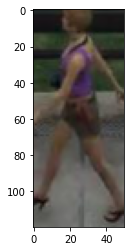

 25%|██▍       | 999/4000 [00:48<02:25, 20.62it/s]

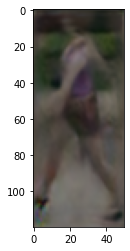

 50%|████▉     | 1998/4000 [01:36<01:37, 20.48it/s]

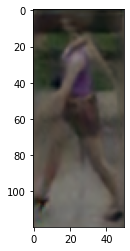

 75%|███████▍  | 2997/4000 [02:25<00:49, 20.46it/s]

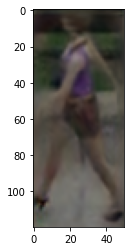

100%|█████████▉| 3999/4000 [03:15<00:00, 20.24it/s]

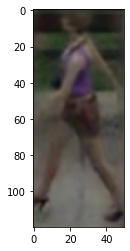

100%|██████████| 4000/4000 [03:15<00:00, 20.48it/s]


In [238]:
img_from = jta_parsed[104]['img']
show_image(img_from)
w_from = get_image_code(generator, img_from, num_iters = 4000, init = "random", show_every = 1000)

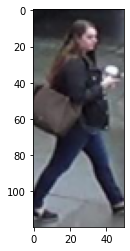

 25%|██▍       | 999/4000 [00:49<02:28, 20.23it/s]

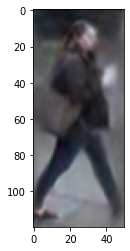

 50%|████▉     | 1997/4000 [01:38<01:39, 20.22it/s]

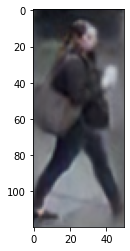

 75%|███████▍  | 2999/4000 [02:28<00:49, 20.19it/s]

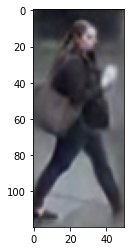

100%|█████████▉| 3998/4000 [03:18<00:00, 20.21it/s]

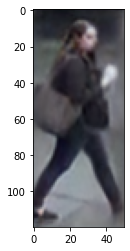

100%|██████████| 4000/4000 [03:18<00:00, 20.16it/s]


In [217]:
img_to = duke[1070]['img']
show_image(img_to)
w_to = get_image_code(generator, img_to, num_iters = 4000, init = "random", show_every = 1000)

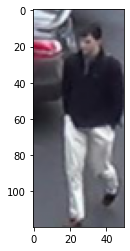

 25%|██▍       | 999/4000 [00:49<02:27, 20.40it/s]

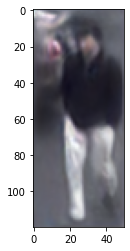

 50%|████▉     | 1998/4000 [01:38<01:38, 20.32it/s]

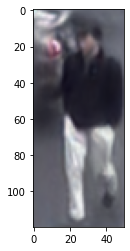

 75%|███████▍  | 2997/4000 [02:27<00:49, 20.19it/s]

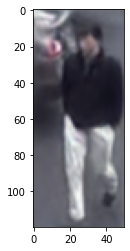

100%|█████████▉| 3999/4000 [03:17<00:00, 20.20it/s]

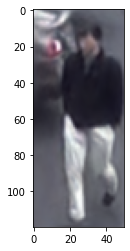

100%|██████████| 4000/4000 [03:17<00:00, 20.26it/s]


In [239]:
img_to_2 = duke[200]['img']
show_image(img_to_2)
w_to_2 = get_image_code(generator, img_to_2, num_iters = 4000, init = "random", show_every = 1000)

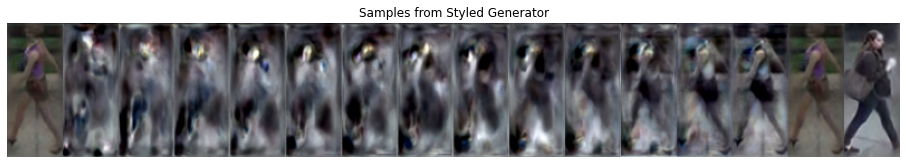

In [219]:
img_list = []
# img_list.append(get_image(generator, w_from))
st = get_expanded_style_code(get_mean_style(generator))
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    w_s = torch.cat([w_from[:,0:i,:], w_to[:,i:14:,:]], 1)
    img_list.append(get_image(generator, w_s))

# img_list.append(get_image(generator, w_to))
    
show_batch_from_list(img_list)

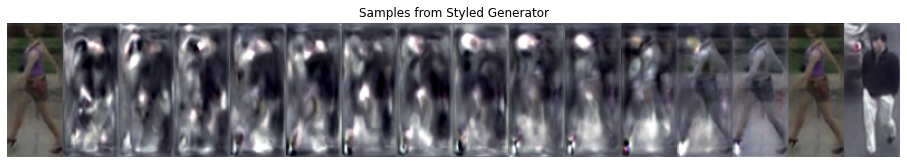

In [241]:
img_list = []
img_list.append(get_image(generator, w_from))
st = get_expanded_style_code(get_mean_style(generator))
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    w_s = torch.cat([w_from[:,0:i,:], w_to_2[:,i:14:,:]], 1)
    img_list.append(get_image(generator, w_s))

img_list.append(get_image(generator, w_to_2))
    
show_batch_from_list(img_list)

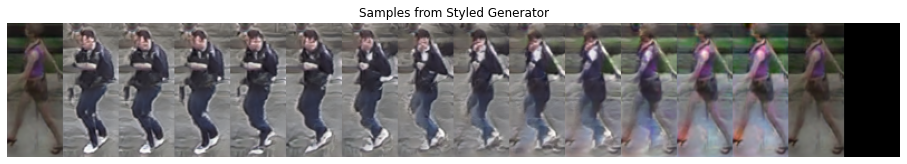

In [228]:
img_list = []
# img_list.append(get_image(generator, w_from))
st = get_expanded_style_code(get_mean_style(generator))
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    w_s = torch.cat([w_from[:,0:i,:], st[:,i:14:,:]], 1)
    img_list.append(get_image(generator, w_s))

# img_list.append(get_image(generator, w_to))
    
show_batch_from_list(img_list)